In [22]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding

In [23]:
data = pd.read_csv("tamilmurasu_dataset.csv")
data.head()

,news_id,news_date,news_category,news_title,news_article
0,6,1/6/2011 2:45:49 PM,மர்மம்,தூக்கில் தொங்கும் சேவல்கள் திருடர்களை காவு வாங...,"நாலு ஆள் உயரம், முறுக்கு மீசை, கையில் வீச்சரிவ..."
1,9,1/6/2011 2:56:51 PM,மர்மம்,பவுர்ணமி ஜாமத்தில் மாயமான கர்ப்பிணி,அமானுஷ்யமான சம்பவங்கள் நம்மை சுற்றி ஆங்காங்கே ...
2,10,1/6/2011 3:02:00 PM,இந்தியா,காமன்வெல்த் ஊழல்: சுரேஷ் கல்மாடியிடம் 102 கேள்...,காமன்வெல்த் போட்டி ஏற்பாட்டில் நடைபெற்ற முறைகே...
3,11,1/6/2011 3:08:15 PM,மர்மம்,மச்சுபிச்சு மலை ரகசியம்,தென்அமெரிக்க நாடான பெருவில் காடுகள் மிகவும் பய...
4,12,1/6/2011 3:09:20 PM,மர்மம்,ரத்த பலி வாங்கும் விபரீத ஆவி!,கடந்த 18ம் தேதி சாயங்காலம்... அடைமழையை கிழித்த...


In [24]:
stopwords=['அங்கு',
 'அங்கே',
 'அடுத்த',
 'அதனால்',
 'அதன்',
 'அதற்கு',
 'அதிக',
 'அதில்',
 'அது',
 'அதே',
 'அதை',
 'அந்த',
 'அந்தக்',
 'அந்தப்',
 'அன்று',
 'அல்லது',
 'அவன்',
 'அவரது',
 'அவர்',
 'அவர்கள்',
 'அவள்',
 'அவை',
 'ஆகிய',
 'ஆகியோர்',
 'ஆகும்',
 'இங்கு',
 'இங்கே',
 'இடத்தில்',
 'இடம்',
 'இதனால்',
 'இதனை',
 'இதன்',
 'இதற்கு',
 'இதில்',
 'இது',
 'இதை',
 'இந்த',
 'இந்தக்',
 'இந்தத்',
 'இந்தப்',
 'இன்னும்',
 'இப்போது',
 'இரு',
 'இருக்கும்',
 'இருந்த',
 'இருந்தது',
 'இருந்து',
 'இவர்',
 'இவை',
 'உன்',
 'உள்ள',
 'உள்ளது',
 'உள்ளன',
 'எந்த',
 'என',
 'எனக்',
 'எனக்கு',
 'எனப்படும்',
 'எனவும்',
 'எனவே',
 'எனினும்',
 'எனும்',
 'என்',
 'என்ன',
 'என்னும்',
 'என்பது',
 'என்பதை',
 'என்ற',
 'என்று',
 'என்றும்',
 'எல்லாம்',
 'ஏன்',
 'ஒரு',
 'ஒரே',
 'ஓர்',
 'கொண்ட',
 'கொண்டு',
 'கொள்ள',
 'சற்று',
 'சிறு',
 'சில',
 'சேர்ந்த',
 'தனது',
 'தன்',
 'தவிர',
 'தான்',
 'நான்',
 'நாம்',
 'நீ',
 'பற்றி',
 'பற்றிய',
 'பல',
 'பலரும்',
 'பல்வேறு',
 'பின்',
 'பின்னர்',
 'பிற',
 'பிறகு',
 'பெரும்',
 'பேர்',
 'போது',
 'போன்ற',
 'போல',
 'போல்',
 'மட்டுமே',
 'மட்டும்',
 'மற்ற',
 'மற்றும்',
 'மிக',
 'மிகவும்',
 'மீது',
 'முதல்',
 'முறை',
 'மேலும்',
 'மேல்',
 'யார்',
 'வந்த',
 'வந்து',
 'வரும்',
 'வரை',
 'வரையில்',
 'விட',
 'விட்டு',
 'வேண்டும்',
 'வேறு']

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
news_title=data["news_title"].apply(str)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer=factory.create_stemmer()


def clean(text):
    # Lowering letters
    text = text.lower()
    # Removing html tags
    text = re.sub('<[^>]*>', '', text)
    # Removing emails
    text = re.sub('\S*@\S*\s?', '', text)
    # Removing urls
    text = re.sub('https?://[A-Za-z0-9]','',text)
    # Removing numbers
    text = re.sub('[^a-zA-Z]',' ',text)
    for word in stopwords:
        token = ' '+word+' '
        text = text.replace(token,'')
        text = text.replace('','')
    text_stem = stemmer.stem(text)
    return text_stem


tokenizer = Tokenizer()
tokenizer.fit_on_texts(news_title)
all_labels =np.array(tokenizer.texts_to_sequences(news_title))


In [6]:
print(tokenizer.word_index)

{'பேர்': 1, 'கைது': 2, '2': 3, 'அருகே': 4, 'பலி': 5, 'அரசு': 6, 'மீது': 7, 'பரபரப்பு': 8, 'கொலை': 9, '3': 10, 'ரூ': 11, 'இன்று': 12, 'மக்கள்': 13, 'லட்சம்': 14, 'நாளை': 15, 'மத்திய': 16, 'தேர்தல்': 17, 'பெண்': 18, '5': 19, 'கோடி': 20, 'போலீஸ்': 21, 'சாவு': 22, 'திமுக': 23, 'வழக்கு': 24, '4': 25, 'கொள்ளை': 26, 'சென்னை': 27, 'விசாரணை': 28, 'முதல்வர்': 29, 'திடீர்': 30, 'வேண்டும்': 31, 'அதிமுக': 32, 'வாலிபர்': 33, 'அமைச்சர்': 34, 'பேட்டி': 35, 'தமிழக': 36, 'தகவல்': 37, 'முடிவு': 38, 'அறிவிப்பு': 39, 'போராட்டம்': 40, 'மோதல்': 41, 'அதிரடி': 42, 'தற்கொலை': 43, 'பறிமுதல்': 44, 'இருந்து': 45, 'உத்தரவு': 46, 'பாஜ': 47, 'விழா': 48, '10': 49, 'தேதி': 50, 'பஸ்': 51, 'புகார்': 52, 'புதிய': 53, 'பேச்சு': 54, 'கோயிலில்': 55, 'மீண்டும்': 56, 'கடும்': 57, 'க': 58, 'நடவடிக்கை': 59, 'முதல்': 60, 'ஸ்டாலின்': 61, 'உள்பட': 62, 'ஆயிரம்': 63, '6': 64, 'பணம்': 65, 'திருவள்ளூர்': 66, 'மு': 67, 'தடை': 68, 'விவகாரம்': 69, 'பி': 70, 'போலீசார்': 71, 'லாரி': 72, 'மோதி': 73, 'ரயில்': 74, 'வீட்டில்': 75, 'பயங்கரம்': 7

In [7]:
#Encode all words into numbers
all_encoded_texts = tokenizer.texts_to_sequences(news_title)
all_encoded_texts = np.array(all_encoded_texts)

In [8]:
# Ensure that all files are having the exact same length. In this case it's 500 words
all_encoded_texts = sequence.pad_sequences(all_encoded_texts, maxlen=100)

In [9]:
#X_train(data)
all_encoded_texts.shape

(126746, 100)

In [10]:
labels = np.array([0] * len(data))
labels.shape

(126746,)

In [11]:
all_labels = labels[:, np.newaxis]
one_hot_encoder = OneHotEncoder(sparse=False)
all_labels = one_hot_encoder.fit_transform(all_labels)
all_labels.shape

(126746, 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(all_encoded_texts ,all_labels, test_size=0.2, random_state=11)

In [13]:
len(tokenizer.word_index)

70616

In [14]:
# Construct the neural network
model = Sequential()
model.add(Embedding(input_dim=70616, output_dim=32, input_length=100))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='categorical_crossentropy', 
              optimizer="adam",
              metrics=['accuracy'])

In [15]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           2259712   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 2,313,013
Trainable params: 2,313,013
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
print(all_encoded_texts.shape)
print(all_labels.shape)

(126746, 100)
(126746, 1)


In [25]:
history = model.fit(all_encoded_texts, all_labels, epochs=4, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/4
2927/3961 [=====================>........] - ETA: 1:21 - loss: 0.0000e+00 - accuracy: 0.1986

InvalidArgumentError:  indices[23,95] = 70616 is not in [0, 70616)
	 [[node sequential/embedding/embedding_lookup (defined at Users\PAVITH~1\AppData\Local\Temp/ipykernel_12184/2806664964.py:1) ]] [Op:__inference_train_function_3102]

Errors may have originated from an input operation.
Input Source operations connected to node sequential/embedding/embedding_lookup:
 sequential/embedding/embedding_lookup/1902 (defined at python\lib\contextlib.py:119)

Function call stack:
train_function


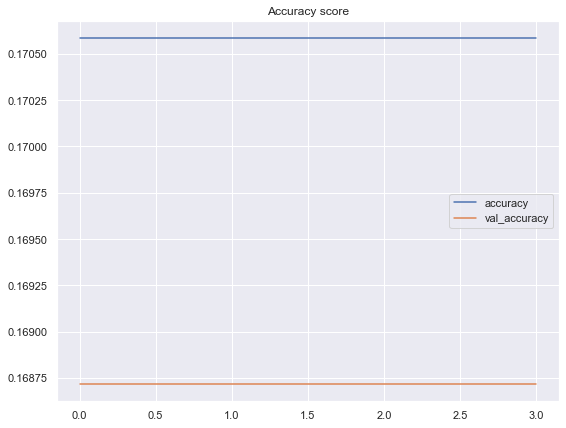

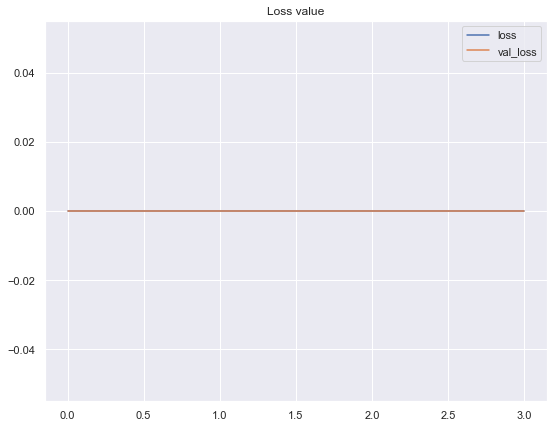

In [27]:
plt.figure(figsize=(9,7))
plt.title('Accuracy score')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(9,7))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [28]:
predictions = model.predict(X_test)
predictions = one_hot_encoder.inverse_transform(predictions)

In [29]:
y_test_evaluate = np.argmax(y_test, axis=1)

In [30]:
cm = confusion_matrix(y_test_evaluate, predictions)

In [31]:
plt.figure(figsize=(8,8))
plt.title('Confusion matrix on test data')
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, 
            cmap=plt.cm.Blues, cbar=False, annot_kws={'size':14})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000024448BA7430> (for post_execute):


KeyboardInterrupt: 